<06. 토픽 모델링 (20개 주제를 가진 뉴스그룹 데이터 활용)>
- (머신러닝 기반의) 토픽 모델링: 문서집합에 숨은 주제를 찾아내기
: 숨겨진 주제를 효과적으로 표현할 수 있는 중심단어를 함축적으로 추출해냄
- 많이 사용되는 기법 2가지: 1) LSA (Latent Semantic Analysis), 2) LDA (Latent Dirichlet Allocation, 차원축소의 LDA와 전혀 다름)

- 20가지 뉴스그룹 데이터 활용하기:
1) 8개 주제를 추출 (모토사이클, 야구, 그래픽스, 윈도우, 중동, 기독교, 전자공학, 의학)
2) 텍스트에 LDA기반 토픽모델링 적용
cf. 사이킷런도 LDA를 제공함 (토픽 모델링: LatentDirichletAllocation 클래스)

먼저, 토픽모델링을 위해 fetch_20newsgroups() API는 categories 모수를 통해, 특정 주제만 필터링하고,
추출된 텍스트를 Count 기반으로 벡터화 변환
cf. LDA는 Count 기반의 벡터화만 사용
- max_features=1000 (word 피처의 개수를 제한)
- ngram_range는 (1,2)로 설정하여 피처 백터화 변환하기

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#8가지 주제 추출하기:
cats=['rec.motorcycles','rec.sport.baseball','comp.graphics','comp.windows.x','talk.politics.mideast'
     ,'soc.religion.christian','sci.electronics','sci.med']

news_df=fetch_20newsgroups(subset='all',remove=('headers','footers','quotes'),categories=cats,random_state=0)

count_vect=CountVectorizer(max_df=0.95, max_features=1000, min_df=2, stop_words='english',ngram_range=(1,2))
feat_vect=count_vect.fit_transform(news_df.data)
print('CountVectorizer Shale:',feat_vect.shape)

CountVectorizer Shale: (7862, 1000)


: (CountVectorizer 객체변수인) feat_vect는 1) 총 7,682개 문서가, 2) 1,000개의 피처로 구성된 행렬데이터 (피처백터화 된)다.

- 이제, 피처백터화된 데이터셋에 대해, LDA 토픽모델링 수행하기:
1) 토픽 개수는 (위 뉴스그룹에서 추출한 주제와 같은) 8개로 정함
- LatentDirichletAllocation 클래스의 n_components 모수를 사용하여, 이 토픽개수를 조정하면 된다.

In [3]:
lda=LatentDirichletAllocation(n_components=8, random_state=0)
lda.fit(feat_vect)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=8, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

: LatentDirichletAllocation.fit(데이터셋) -> 하면, LatentDirichletAllocation 객체는, components_ 속성값을 가지게 된다.

- components_는 각 토필마다 각 word 피처가 얼마나 많이 그 토픽에 할당되었는지 수치를 갖고 있다.
(값이 클수록 해당 word 피처는 그 토픽의 중심단어임)
- 아래에서 components_의 형태, 속성값 확인하자:

In [5]:
print(lda.components_.shape)
lda.components_

(8, 1000)


array([[3.60992018e+01, 1.35626798e+02, 2.15751867e+01, ...,
        3.02911688e+01, 8.66830093e+01, 6.79285199e+01],
       [1.25199920e-01, 1.44401815e+01, 1.25045596e-01, ...,
        1.81506995e+02, 1.25097844e-01, 9.39593286e+01],
       [3.34762663e+02, 1.25176265e-01, 1.46743299e+02, ...,
        1.25105772e-01, 3.63689741e+01, 1.25025218e-01],
       ...,
       [3.60204965e+01, 2.08640688e+01, 4.29606813e+00, ...,
        1.45056650e+01, 8.33854413e+00, 1.55690009e+01],
       [1.25128711e-01, 1.25247756e-01, 1.25005143e-01, ...,
        9.17278769e+01, 1.25177668e-01, 3.74575887e+01],
       [5.49258690e+01, 4.47009532e+00, 9.88524814e+00, ...,
        4.87048440e+01, 1.25034678e-01, 1.25074632e-01]])

: components_는 array[8,4000]으로 구성됨 (즉, 8개의 토픽별로, 1,000개의 단어 피처가 해당 토픽별로 연관도 값을 가짐)
ex. components_array의 0번째 행, 10번째 열 값
-> 토픽 0번에 대해서 피처백터화된 행렬에서, 10번째 열에 해당하는 피처가 (토픽 0번에 관련되는) 수치값을 가짐.
그러나, lda_model.components_값만 봐서는, 각 토픽별 단어 연관도를 보기 힘들다.

- 따라서, display_topics()함수를 만들어, 각 토픽별로 연관도가 높은 순서대로 단어들을 나열해 보자:

In [6]:
def display_topics(model, feature_names, no_top_words):
    for topic_index, topic in enumerate(model.components_):
        print('Topic #', topic_index)
        
        #components_array에서, 가장 값이 큰 순서대로 정렬했을 때, 그 값의 array 인덱스를 반환하기:
        topic_word_indexes=topic.argsort()[::-1]
        top_indexes=topic_word_indexes[:no_top_words]
        
        #top_indexes 대상인 인덱스별로, feature_names에 해당하는 단어피처 추출 후, join으로 concat하기:
        feature_concat=''.join([feature_names[i] for i in top_indexes])
        print(feature_concat)
        
#CountVectorizer 객체 내의 전체 단어들의 명칭을 get_features_names()를 써서 추출하기:
feature_names=count_vect.get_feature_names()

#토픽마다 가장 연관도가 높은 단어들을 15개씩 추출하기:
display_topics(lda,feature_names,15)

Topic # 0
year10gamemedicalhealthteam1220diseasecancer1993gamesyearspatientsgood
Topic # 1
donjustlikeknowpeoplesaidthinktimevedidnrightgoingsayllway
Topic # 2
imagefilejpegprogramgifimagesoutputformatfilescolorentry00usebit03
Topic # 3
likeknowdonthinkusedoesjustgoodtimebookreadinformationpeopleusedpost
Topic # 4
armenianisraelarmeniansjewsturkishpeopleisraelijewishgovernmentwardos dosturkeyarabarmenia000
Topic # 5
educomavailablegraphicsftpdatapubmotifmailwidgetsoftwaremitinformationversionsun
Topic # 6
godpeoplejesuschurchbelievechristdoeschristiansaythinkchristiansbiblefaithsinlife
Topic # 7
usedosthankswindowsusingwindowdoesdisplayhelplikeproblemserverneedknowrun


: Topic #0, #5, #7이 애매한 주제어들이 추출되어 목적대로 잘 되지 않는 경우도 발생하였다.

<07. 문서 군집화 소개/실습 (with Opinion review 데이터셋)>

- 문서 군집화 (Document Clustering)
: 비슷한 텍스트 구성의 문서를 (같은 카테고리로 분류해) 묶어주는 것이다.
cf. (이전) 텍스트분류 기반의 문서분류: 이와 유사하지만, 이는 사전에 결정 카테고리값을 가진 학습 데이터셋이 필요했음
-> But, 문서군집화에서는 학습데이터셋이 불필요한 비지도학습에 속함 (차이점).
- 이전 장에서 배운 군집화 기법을 활용함.

[Opinion Review 데이터셋을 이용하여, 문서군집화 수행하기]
- 데이터: Opinion Review 데이터셋으로, 51개 텍스트 파일로 구성되며, 각 파일은 호텔(Tripadvisor), 자동차(Edmunds.com), 전자제품(Amazon.com) 사이트에서 가져온 리뷰문서다.
각 문서는 약 100개의 문장을 가짐.
- 위 데이터를 문서군집화 기법으로, 각 리뷰를 분류해 보자.

In [1]:
import pandas as pd
import glob, os

path=r'Z:\python\OpinosisDataset1.0\topics'
all_files=glob.glob(os.path.join(path,"*.data"))
filename_list=[]
opinion_text=[]

for file_ in all_files:
    df=pd.read_table(file_, index_col=None, header=0, encoding='latin1')
    filename_=file_.split('\\')[-1]
    filename=filename_.split('.')[0]
    filename_list.append(filename)
    opinion_text.append(df.to_string())
    
document_df=pd.DataFrame({'filename':filename_list,'opinion_text':opinion_text})
document_df.head()

C:\Users\Jiwon\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  # Remove the CWD from sys.path while we load stuff.


,filename,opinion_text
0,eyesight-issues_amazon_kindle,It feels as easy to read as the K1 but doe...
1,battery-life_netbook_1005ha,"6GHz 533FSB cpu, glossy display, 3, Cell 2..."
2,service_swissotel_hotel_chicago,Mediocre room and service for a very extr...
3,accuracy_garmin_nuvi_255W_gps,", and is very, very acc..."
4,battery-life_amazon_kindle,After I plugged it in to my USB hub on my ...


: 위를 보면, filename (각 파일명) 만 보더라도, 의견 텍스트 (opinion_text)가 어떤 물건에 대한 리뷰인지 알 수 있다.

- 다음으로, 문서를 TF-IDF 형태로 피처 백터화 하자.
1) tokenizer는 이전 예제에서 Lemmatization을 구현한 LemNormalize() 함수를 이용함.
2) ngram=(1,2).
3) min_df와 max_df로 범위를 설정해 피처 개수를 제한함.
4) TfidfVectorizer의 fit_transform()의 인자로, document_df 데이터프레임의 opinion_text 열을 입력시키면,
개별 문서 텍스트에 대해 TF-IDF 변환된, 피처 백터화된 행렬이 나옴.

In [3]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

# nltk는 
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect=TfidfVectorizer(tokenizer=LemNormalize, stop_words='english', ngram_range=(1,2), min_df=0.05, max_df=0.85)

#opinion_text 열 값으로, 피처백터화 진행하기:
feature_vect=tfidf_vect.fit_transform(document_df['opinion_text'])

C:\Users\Jiwon\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


- 다음으로는, 문서별 텍스트가, TF-IDF변환된 피처벡터화 행렬데이터에 대해, 군집화를 수행 -> 어떤 문서끼리 군집되는지 확인하자.
- 군집화 기법은 K-평균을 사용.
- 문서 유형은 크게 3가지: (1) 전자제품, (2) 자동차, (3) 호텔.
- 먼저 5개의 중심(Centroid) 기반으로 어떻게 군집화되는지 확인하자.
- 최대 반복횟수: max_iter=10000
- KMeans 수행한 뒤, 1) 군집의 레이블값, 2) 중심별로 할당된 데이터셋의 좌표값 구함.

In [6]:
from sklearn.cluster import KMeans

#5개 집합으로 군집화 수행하기:
km_cluster=KMeans(n_clusters=5,max_iter=10000,random_state=0)
km_cluster.fit(feature_vect)
cluster_label=km_cluster.labels_
cluster_centers=km_cluster.cluster_centers_

- 다음은, 각 데이터마다 할당된 군집의 레이블을, 파일명과 파일내용을 가진 document_df 데이터프레임에 'cluster_label'열을 추가해 저장하자.
각 파일명은 리뷰 의견에 대한 주제를 나타냄.
군집이 각 주제별로 유사한 형태로 잘 구성됐는지 알아보자.

In [7]:
document_df['cluster_label']=cluster_label
document_df.head()

,filename,opinion_text,cluster_label
0,eyesight-issues_amazon_kindle,It feels as easy to read as the K1 but doe...,4
1,battery-life_netbook_1005ha,"6GHz 533FSB cpu, glossy display, 3, Cell 2...",4
2,service_swissotel_hotel_chicago,Mediocre room and service for a very extr...,2
3,accuracy_garmin_nuvi_255W_gps,", and is very, very acc...",3
4,battery-life_amazon_kindle,After I plugged it in to my USB hub on my ...,4


In [9]:
document_df[document_df['cluster_label']==0].sort_values(by='filename') #0번(호텔)로 분류된 데이터만 (filename 알파벳 오름차순으로 정렬)

,filename,opinion_text,cluster_label
21,comfort_honda_accord_2008,"Drivers seat not comfortable, the car its...",0
47,comfort_toyota_camry_2007,Ride seems comfortable and gas mileage fa...,0
10,gas_mileage_toyota_camry_2007,Ride seems comfortable and gas mileage fa...,0
46,interior_honda_accord_2008,I love the new body style and the interior...,0
9,interior_toyota_camry_2007,"First of all, the interior has way too ma...",0
39,mileage_honda_accord_2008,"It's quiet, get good gas mileage and look...",0
38,performance_honda_accord_2008,"Very happy with my 08 Accord, performance i...",0
8,quality_toyota_camry_2007,I previously owned a Toyota 4Runner which ...,0
14,seats_honda_accord_2008,Front seats are very uncomfor...,0
36,transmission_toyota_camry_2007,"After slowing down, transmission has to b...",0


In [10]:
from sklearn.cluster import KMeans

# 3개의 집합으로 군집화 
km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_


# 소속 클러스터를 cluster_label 컬럼으로 할당하고 cluster_label 값으로 정렬
document_df['cluster_label'] = cluster_label
document_df.sort_values(by='cluster_label')

,filename,opinion_text,cluster_label
50,staff_bestwestern_hotel_sfo,Staff are friendly and hel...,0
37,price_holiday_inn_london,"All in all, a normal chain hotel on a nice...",0
24,food_holiday_inn_london,The room was packed to capacity with queu...,0
23,bathroom_bestwestern_hotel_sfo,"The room was not overly big, but clean and...",0
40,staff_swissotel_chicago,The staff at Swissotel were not particula...,0
20,rooms_swissotel_chicago,The Swissotel is one of our favorite hotel...,0
19,service_bestwestern_hotel_sfo,Both of us having worked in tourism for o...,0
18,parking_bestwestern_hotel_sfo,Parking was expensive but I think this is ...,0
41,rooms_bestwestern_hotel_sfo,"Great Location , Nice Rooms , Helpless...",0
16,room_holiday_inn_london,"We arrived at 23,30 hours and they could n...",0


[군집별 핵심단어 추출하기]
- 각 군집(클러스터)에 속한 문서는, 핵심단어를 주축으로 군집화됨.
- KMeans 객체는, 각 군집을 구성하는 단어피처가 군집의 중심(Centroid)을 기준으로 얼마나 가깝게 위치했는지 (clusters_centers_) 속성에서 (배열 값)으로 제공한다 (즉, 행=개별군집, 열=개별피처를 나타내며, 각 배열 내의 값은 개별군집 내의 상대위치를 숫자값으로 표현한 좌표값).
ex. cluster_centers[0,1]: 0번 군집에서 2번째 피처의 위치값임.

- 이제, 앞 예제에서 군집 3개로 만든 KMeans 객체인 km_cluster에서 cluster_centers_ 속성값을 확인해 보자:

In [11]:
cluster_centers=km_cluster.cluster_centers_
print('cluster_centers shape:',cluster_centers.shape) #3행 2409열 (전체)
print(cluster_centers)

cluster_centers shape: (3, 2409)
[[0.         0.00170335 0.0025537  ... 0.0032582  0.00349413 0.        ]
 [0.         0.00137309 0.         ... 0.         0.         0.        ]
 [0.01819865 0.         0.         ... 0.         0.         0.00471073]]


: cluster_centers_는 (3,2409) 배열 (즉, 군집 3개, 단어 피처는 2409개; 각 행의 배열값은, 각 군집 내의 2409개 피처의 위치가, 개별 중심과 얼마나 가까운지 상대값(0~1, 1에 가까울수록 중심과 가까운 값)으로 나타냄)

- 다음으로, cluster_centers_ 속성값을 이용해, 각 군집별 핵심단어를 찾자.
- cluster_centers_의 속성: 넘파이 ndarray이므로, ndarray의 argsort()[:,::-1] (: cluster_centers 배열 내의 값이 큰 순으로 정렬된 위치인덱스 값을 반환해 줌 (즉, 큰 값을 가진 배열 내 위치인덱스값을 반환)).
cf. 위치 인덱스 값을 사용하여, 핵심단어 피처이름을 출력해낼 수 있기 때문.
- 위를 위하여, 새로운 함수 생성 (get_cluster_details())
(즉, cluster_centers_ 배열 안에서, 가장 값이 큰 데이터의 위치 인덱스를 추출한 뒤, 해당 인덱스를 이용해 핵심단어이름과 그 때의 상대위치값을 추출해 cluster_details라는 딕셔너리 객체변수에 기록/반환시킴).


In [15]:
#군집별 상위 n개 핵심단어, 그 단어의 중심위치 상대값, 대상 파일명을 반환하는 사용자 정의함수 get_cluster_details 만들기:
def get_cluster_details(cluster_model, cluster_data, feature_names, clusters_num, top_n_features=10):
    cluster_details={}
    
    #cluster_centers 배열값이 큰 순으로 정렬된 인덱스값 반환하기:
    #군집 중심점(centroid)마다 할당된 단어피처들의 거리값이 큰 순으로 값을 구하기 위함
    centroid_feature_ordered_ind=cluster_model.cluster_centers_.argsort()[:,::-1]
    
    #개별 군집별로 반복하면서 핵심단어, 그 단어의 중심위치 상대값, 대상 파일명을 입력하기:
    for cluster_num in range(clusters_num):
        
        #개별 군집별 정보를 담을 데이터 초기화하기:
        cluster_details[cluster_num]={}
        cluster_details[cluster_num]['cluster']=cluster_num
        
        #cluster_centers_.argsort()[:,::-1]로 구한 인덱스를 이용해 상위 n개 피처단어를 구하기:
        top_feature_indexes=centroid_feature_ordered_ind[cluster_num, :top_n_features]
        top_features=[feature_names[ind] for ind in top_feature_indexes]
        
        #top_feature_indexes로 해당 피처단어의 중심위치 상대값 구하기:
        top_feature_values=cluster_model.cluster_centers_[cluster_num, top_feature_indexes].tolist()
        
        #cluster_details 딕셔너리 객체에, 개별 군집별 핵심단어와 중심위치 상대값, 해당 파일명을 입력하기:
        cluster_details[cluster_num]['top_features']=top_features
        cluster_details[cluster_num]['top_features_value']=top_feature_values
        filenames=cluster_data[cluster_data['cluster_label']==cluster_num]['filename']
        filenames=filenames.values.tolist()
        
        cluster_details[cluster_num]['filenames']=filenames
        
    return cluster_details

: get_cluster_details()를 호출하면, 딕셔너리를 원소로 갖는 리스트인 cluster_details를 반환함.
(cluster_details는 1) 개별 군집번호, 2) 핵심 단어, 3) 핵심단어 중심 위치 상대값, 4) 파일명 속성 값 정보 포함)
- 위를 보기좋게 표현하기 위해, print_cluster_details() 함수를 만들자:

In [16]:
def print_cluster_details(cluster_details):
    for cluster_num, cluster_detail in cluster_details.items():
        print('#### Cluster {0}'.format(cluster_num))
        print('상위 피처들:',cluster_detail['top_features'])
        print('리뷰 파일명:',cluster_detail['filenames'][:7])
        print('==========================================')

: 위에서 만든 (1) get_cluster_details(), (2) print_cluster_details()를 호출하자.
(1) get_cluster_details() 호출 시 인자: KMeans 군집화 객체, 파일명 추출을 위한 document_df 데이터프레임, 핵심단어 추출을 위한 피처명 리스트, 전체 군집수, 핵심단어 추출 개수.
cf. 피처명 리스트: (앞에서 TF-IDF 변환된 tfidf_vect 객체에서) get_feature_names()로 추출.

In [17]:
feature_names=tfidf_vect.get_feature_names()
cluster_details=get_cluster_details(cluster_model=km_cluster, cluster_data=document_df, feature_names=feature_names,
                                   clusters_num=3, top_n_features=10)
print_cluster_details(cluster_details)

#### Cluster 0
상위 피처들: ['room', 'hotel', 'service', 'location', 'staff', 'food', 'clean', 'bathroom', 'parking', 'room wa']
리뷰 파일명: ['service_swissotel_hotel_chicago', 'free_bestwestern_hotel_sfo', 'service_holiday_inn_london', 'location_bestwestern_hotel_sfo', 'room_holiday_inn_london', 'parking_bestwestern_hotel_sfo', 'service_bestwestern_hotel_sfo']
#### Cluster 1
상위 피처들: ['interior', 'seat', 'mileage', 'comfortable', 'car', 'gas', 'transmission', 'gas mileage', 'ride', 'comfort']
리뷰 파일명: ['quality_toyota_camry_2007', 'interior_toyota_camry_2007', 'gas_mileage_toyota_camry_2007', 'seats_honda_accord_2008', 'comfort_honda_accord_2008', 'transmission_toyota_camry_2007', 'performance_honda_accord_2008']
#### Cluster 2
상위 피처들: ['screen', 'battery', 'life', 'battery life', 'keyboard', 'kindle', 'size', 'button', 'easy', 'voice']
리뷰 파일명: ['eyesight-issues_amazon_kindle', 'battery-life_netbook_1005ha', 'accuracy_garmin_nuvi_255W_gps', 'battery-life_amazon_kindle', 'satellite_garmin_nuvi_25

: (1) 포터블 전자제품, (2) 호텔, (3) 자동차 (모두 관련된 단어들이 정리되어 있음).

<08. 문서유사도>

[문서 유사도 측정방법: 코사인 유사도]
- 문서 간 유사도 비교는 보통 코사인 유사도 (Cosine Similarity)로 측정
- 코사인 유사도: 벡터 간 유사도를 비교할 때, (크기보다는) 상호 방향성이 얼마나 유사한지에 관심
(즉, 두 벡터 사이의 사이각을 구해, 얼마나 유사한지 수치화한 것)
- 두 벡터 A, B의 코사인 값 계산하는 공식에 기반하여, 
Similarity=cos(theta)=(A*B)/[norm(A)*norm(B)] (분자: 백터의 내적(Dot product); 분모: 각 벡터의 크기(Norm))

- 실습) 코사인 유사도 기반으로 문서 간 유사도 계산하기:
(1) 먼저, 넘파이 배열 2개에 대한 코사인 유사도를 계산해 주는, 사용자정의함수 cos_similarity() 정의하자:

In [18]:
import numpy as np

def cos_similarity(v1,v2):
    dot_product=np.dot(v1,v2)
    l2_norm=(np.sqrt(sum(np.square(v1)))*np.sqrt(sum(np.square(v2))))
    similarity=dot_product/l2_norm
    
    return similarity

- 이제, doc_list로 정의된 3개의 짧은 문서간에 유사도를 비교하기 위해, 이 문서를 TF-IDF로 백터화된 행렬로 변환하자:

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list=['if you take the blue pill, the story ends',
         'if you take the red pill, you stay in Wonderland',
         'if you take the red pill, I show you how deep the rabbit hole goes']

tfidf_vect_simple=TfidfVectorizer()
feature_vect_simple=tfidf_vect_simple.fit_transform(doc_list)
print(feature_vect_simple.shape)

(3, 18)


: 반환된 행렬은 '희소행렬'이므로, 앞에서 만들었던 두 개 문서간 유사도를 측정해주는 cos_similarity() 함수의 인자인 배열로 만들기 위해서는 1) 밀집행렬로 변환한 뒤, 2) 다시 각자를 배열로 변환시켜야 된다.
cf. feature_vect_dense[0]: doc_list 1번째 문서의 피처백터화.

In [21]:
#TFidfVectorizer로 transform()한 결과는 희소행렬이므로, 이를 밀집행렬로 변환하기:
feature_vect_dense=feature_vect_simple.todense()

#1번째 문장과 2번째 문장의 피처벡터 추출하기:
vect1=np.array(feature_vect_dense[0]).reshape(-1,)
vect2=np.array(feature_vect_dense[1]).reshape(-1,)

#1번째 문장과 2번째 문장의 피처벡터로 2개 문장간 코사인유사도 구하기:
similarity_simple=cos_similarity(vect1,vect2)
print('문장1과 문장2 간의 코사인유사도: {0:.3f}'.format(similarity_simple))

문장1과 문장2 간의 코사인유사도: 0.402


- 다음으로, 1번째와 3번째 문장, 2번째와 3번째 문장 간의 유사도 측정하기:

In [22]:
vect1=np.array(feature_vect_dense[0]).reshape(-1,)
vect3=np.array(feature_vect_dense[2]).reshape(-1,)
similarity_simple=cos_similarity(vect1,vect3)
print('문장1과 문장3 간의 코사인유사도:{0:.3f}'.format(similarity_simple))

vect2=np.array(feature_vect_dense[1]).reshape(-1,)
vect3=np.array(feature_vect_dense[2]).reshape(-1,)
similarity_simple=cos_similarity(vect2,vect3)
print('문장2과 문장3 간의 코사인유사도:{0:.3f}'.format(similarity_simple))

문장1과 문장3 간의 코사인유사도:0.404
문장2과 문장3 간의 코사인유사도:0.456


- 사이킷런에서도 더욱 간단하게 코사인유사도 측정이 가능: cosine_similarity() 사용 (2개 모수 입력해야: 1) 비교기준이 되는 문서의 피처행렬, 2) 비교되는 문서의 피처행렬)
- cosine_similarity()는 희소행렬/밀집행렬, 행렬/배열 형태가 모두 적용가능.
(즉, 이전에 만들었던 사용자정의함수 cos_similarity()를 통한 변환작업이 불필요)
- 예) 1번째 문서와 비교해, 1) 자기자신, 2) 2번째, 3) 3번째 문서간의 유사도를 측정해 보자:

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair=cosine_similarity(feature_vect_simple[0], feature_vect_simple)
print(similarity_simple_pair)

[[1.         0.40207758 0.40425045]]


In [24]:
#(위와 동일하나) 만약 1이라는 값이 거슬린다면 제거하고 출력시키면 된다.
similarity_simple_pair=cosine_similarity(feature_vect_simple[0], feature_vect_simple[1:])
print(similarity_simple_pair)

[[0.40207758 0.40425045]]


- 마지막으로, 모든 조합에 대한 코사인유사도 값을 출력할 수도 있다 (ndarray형태로 제공됨).

In [25]:
similarity_simple_pair=cosine_similarity(feature_vect_simple, feature_vect_simple)
print(similarity_simple_pair)
print('shape:', similarity_simple_pair.shape)

[[1.         0.40207758 0.40425045]
 [0.40207758 1.         0.45647296]
 [0.40425045 0.45647296 1.        ]]
shape: (3, 3)


: 해석 예) 2번째 행: 2번 문서 & 1, 3번째 문서와의 코사인유사도를 출력함.

[Opinion Review 데이터셋을 이용한 문서 유사도 측정하기]

In [28]:
import pandas as pd
import glob, os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

path=r'Z:\python\OpinosisDataset1.0\topics'
all_files=glob.glob(os.path.join(path,"*.data"))
filename_list=[]
opinion_text=[]

for file_ in all_files:
    df=pd.read_table(file_, index_col=None, header=0, encoding='latin1')
    filename_=file_.split('\\')[-1]
    filename=filename_.split('.')[0]
    filename_list.append(filename)
    opinion_text.append(df.to_string())
    
document_df=pd.DataFrame({'filename':filename_list,'opinion_text':opinion_text})

tfidf_vect=TfidfVectorizer(tokenizer=LemNormalize, stop_words='english',ngram_range=(1,2),min_df=0.05,max_df=0.85)

feature_vect=tfidf_vect.fit_transform(document_df['opinion_text'])

km_cluster=KMeans(n_clusters=3,max_iter=10000,random_state=0)
km_cluster.fit(feature_vect)
cluster_label=km_cluster.labels_
cluster_centers=km_cluster.cluster_centers_
document_df['cluster_label']=cluster_label

C:\Users\Jiwon\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  if sys.path[0] == '':
C:\Users\Jiwon\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


- 이전 절에서, 위 문서를 1) 전자제품, 2) 호텔, 3) 자동차를 주제로 군집화했다. 
- 여기서는 호텔을 주제로 군집화된 문서를 이용해, 특정문서와 다른문서 간 유사도를 측정해 보자.
- 각 문서가 피처백터화된 데이터를 cosiine_similarity()를 써서 상호비교해 유사도를 측정할 것이다.
- 첫째, 이를 위해 1) 호텔을 주제로 군집화된 데이터를 먼저 추출하고, 2) 이 데이터에 해당하는 TfidfVectorizer의 데이터를 추출하자.
(즉, 호텔 군집화 데이터를 기반으로, 별도의 TF-IDF 벡터화를 하지 않고, 바로 위에서 TfdifVectorizer로 만들어진 데이터에서 그대로 추출)
- (1) 데이터프레임의 객체변수인 document_df에서, 호텔로 군집화된 문서의 인덱스를 추출한다.
(2) 추출된 인덱스를 이용해, TfidfVectorizer 객체변수인 feature_vect에서 호텔로 군집화된 문서의 피처백터를 추출한다.

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

#(cluster_label=1)인 데이터는 호텔로 군집화된 데이터임. 데이터프레임에서 해당 인덱스를 추출하기:
hotel_indexes=document_df[document_df['cluster_label']==1].index
print('호텔로 군집화된 문서들의 데이터프레임 인덱스:',hotel_indexes)

#호텔로 군집화된 데이터 중, 1번째 문서를 추출해 파일명 표시하기:
comparison_docname=document_df.iloc[hotel_indexes[0]]['filename']
print('### 비교기준 문서명',comparison_docname,'와 타문서 유사도 ###')

'''document_df에서 추출한 인덱스 객체를, feature_vect로 입력해 호텔 군집화된 feature_vect 추출
이를 이용해 호텔로 군집화된 문서 중, 1번재 문서와 다른 문서간의 코사인유사도 측정'''
similarity_pair=cosine_similarity(feature_vect[hotel_indexes[0]],feature_vect[hotel_indexes])
print(similarity_pair)

호텔로 군집화된 문서들의 데이터프레임 인덱스: Int64Index([8, 9, 10, 14, 21, 36, 38, 39, 46, 47], dtype='int64')
### 비교기준 문서명 quality_toyota_camry_2007 와 타문서 유사도 ###
[[1.         0.23665505 0.13975232 0.11574717 0.23536241 0.12707781
  0.17566316 0.11368021 0.21447282 0.25543232]]


- 위처럼 수치로만 표현하면 와닿지 않으므로, 정렬 & 시각화 하자:
(즉, 1번째 문서와, 다른 문서 간에 유사도가 높은 순으로 정렬 및 시각화. 
cosine_similarity()는 쌍형태의 ndarray를 반환하므로, 이를 판다스 인덱스로 이용하기 위해서, reshape(-1)을 써서 차원을 변경하자.)

Text(0.5, 1.0, 'quality_toyota_camry_2007')

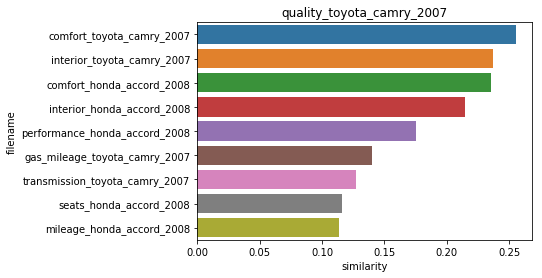

In [30]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#1번째 문서와, 다른문서 간 유사도가 큰 순서대로 정렬한 인덱스를 추출하되, 자기자신은 제외하기:
sorted_index=similarity_pair.argsort()[:,::-1]
sorted_index=sorted_index[:,1:]

#유사도가 큰 순서대로 hotel_indexes를 추출해 재정렬하기:
hotel_sorted_indexes=hotel_indexes[sorted_index.reshape(-1)]

#유사도가 큰 순서대로 유사도값을 재정렬하되, 자기자신은 제외하기:
hotel_1_sim_value=np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value=hotel_1_sim_value[1:]

#유사도가 큰 순서대로 정렬된 인덱스와, 유사도값을 이용해, 파일명과 유사도값을 막대그래프로 시각화하기:
hotel_1_sim_df=pd.DataFrame()
hotel_1_sim_df['filename']=document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity']=hotel_1_sim_value

sns.barplot(x='similarity',y='filename',data=hotel_1_sim_df)
plt.title(comparison_docname)

: 결과적으로, 첫번째 문서 (=quality_toyota_camry_2007)와 가장 비슷한 문서는 (comfort_toyota_camry_2007) (즉, 파란색 맨 위 그래프)이다.

<09. 한글 텍스트 처리: 네이버 영화평점 감성분석>
- 네이버 영화평점 데이터로 감성분석하기.
- 한글 NLP처리는 어렵다.
- 파이썬기반의 한글형태소 패키지: KoNLPy 활용.

- KoNLPy:
1) 파이썬의 대표적인 한글 형태소 패키지
- 형태소: 단어로서 의미를 갖는 최소단위
- 형태소 분석 (Morphological analysis): 말뭉치를 이러한 형태소 어근단위로 쪼개고, 각 형태소에 품사태깅 (POS tagging)을 부착하는 작업
- 5개의 형태소분석 모듈 (꼬꼬마(Kkma), 한나눔(Hannanum), Komoran, 은전한닢 프로젝트(Mecab), Twitter)을 KoNLPy에서 모두 사용 가능
(단, Mecab을 사용하려면, 리눅스 환경의 KoNLPy에서만 가능)

[데이터 로딩]
- 네이버 영화평점 데이터 (3가지 텍스트 데이터셋이 별도로 존재)
(1) ratings_train.txt 파일을 데이터프레임으로 로딩하기 (탭(\t)로 칼럼이 분리됨)

In [1]:
import pandas as pd

train_df=pd.read_csv('ratings_train.txt',sep='\t')
train_df.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [2]:
train_df['label'].value_counts() #학습데이터셋: 레이블값 = 1 (긍정), 0 (부정)

0    75173
1    74827
Name: label, dtype: int64

In [3]:
#(1) train_df: 리뷰텍스트를 가지는 document열에 Null이 일부 존재하므로, 이 값을 공백으로 변환시키기
#(2) 문자아닌 '숫자'의 경우 (단어적인 의미가 부족하므로) 파이썬의 정규 표현식 모듈인 re를 이용해, 이 값도 공백으로 변환시키기
#(테스트데이터셋도 파일 불러온 뒤, 위와 동일한 데이터 가공하기)
import re
train_df=train_df.fillna(' ')

#정규표현식을 이용해, 숫자 -> 공백으로 변경하기 (정규표현식으로 \d는 숫자를 의미함):
train_df['document']=train_df['document'].apply(lambda x:re.sub(r"\d+"," ",x))

#테스트 데이터셋을 불러오고, 동일하게 Null 및 숫자 -> 공백으로 변경하기:
test_df=pd.read_csv('ratings_test.txt',sep='\t')
test_df=test_df.fillna(' ')
test_df['document']=test_df['document'].apply(lambda x:re.sub(r"\d+"," ",x))

- 다음은, TF-IDF 단어벡터화하기.
: 먼저, 각 문장을 (한글 형태소 분석을 통해) 형태소 단어로 토큰화한다.
- (한글 형태소 엔진)은 SNS분석에 적절한 Twitter 클래스를 이용한다.
- Twitter 객체의 morphs() 메서드 이용 -> 입력인자로 들어온 문장을, 형태소 단어형태로 '토큰화'해, 리스트 객체로 반환함.
- 문장을 형태소 단어형태로 반환하는, 별도의 함수 tokenizer를 tw_tokenizer()라는 이름으로 생성함 (이 함수는 뒤에서 사이킷런의 TfidfVectorizer 클래스의 tokenizer로 사용됨).

In [4]:
from konlpy.tag import Twitter

twitter=Twitter()
def tw_tokenizer(text):
    #입력인자로 들어온 텍스트를, 형태소단어로 토큰화해, 리스트 형태로 반환:
    tokens_ko=twitter.morphs(text)
    return tokens_ko

C:\Users\Jiwon\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


- 사이킷런의 TfidfVectorizer 이용해, TF-IDF 피처모델 생성하자.
- tokenizer는 위에서 만든 tw_tokenizer() 함수를 이용.
(ngram=(1,2), min_df=3, max_df=상위90%로 제한)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Twitter 객체의 morphs( ) 객체를 이용한 tokenizer를 사용. ngram_range는 (1,2) 
tfidf_vect = TfidfVectorizer(tokenizer=tw_tokenizer, ngram_range=(1,2), min_df=3, max_df=0.9)
tfidf_vect.fit(train_df['document'])
tfidf_matrix_train = tfidf_vect.transform(train_df['document'])

In [13]:
# Logistic Regression 을 이용하여 감성 분석 Classification 수행. 
lg_clf = LogisticRegression(random_state=0)

# Parameter C 최적화를 위해 GridSearchCV 를 이용. 
params = { 'C': [1 ,3.5, 4.5, 5.5, 10 ] }
grid_cv = GridSearchCV(lg_clf , param_grid=params , cv=3 ,scoring='accuracy', verbose=1 )
grid_cv.fit(tfidf_matrix_train , train_df['label'] )
print(grid_cv.best_params_ , round(grid_cv.best_score_,4))

NameError: name 'tfidf_matrix_train' is not defined

In [14]:
from sklearn.metrics import accuracy_score

# 학습 데이터를 적용한 TfidfVectorizer를 이용하여 테스트 데이터를 TF-IDF 값으로 Feature 변환함. 
tfidf_matrix_test = tfidf_vect.transform(test_df['document'])

# classifier 는 GridSearchCV에서 최적 파라미터로 학습된 classifier를 그대로 이용
best_estimator = grid_cv.best_estimator_
preds = best_estimator.predict(tfidf_matrix_test)

print('Logistic Regression 정확도: ',accuracy_score(test_df['label'],preds))

NotFittedError: TfidfVectorizer - Vocabulary wasn't fitted.

<10. 텍스트분석 실습: 캐글 Mercari Price Suggestion Challenge>
- 일본 대형 온라인 쇼핑몰인 Mercari사 제품에 대해 가격을 예측하기
- 데이터셋 구성: 제품에 대한 여러 속성, 제품설명 등의 텍스트 데이터 포함
- 머신러닝 모델은, 주어진 속성에 따라 제품의 예측가격을 판매자에게 자동 제공할 수 있게 해줌
- 데이터셋 속성:
1) train_id (데이터 아이디), 2) name (제품명), 3) item_condition_id (판매자가 제공하는 제품상태), 4) category_name (카테고리이름), 5) brand_name (브랜드 이름), 6) price (제품가격, 예측을 위한 타겟 속성), 7) shipping (배송비 여부, 1이면 무료, 0이면 소비자가 부담), 8) item_description (제품에 대한 설명)
- Price: 예측해야 할 타겟 값.
- 회귀로 피처를 학습한 후, 가격을 예측하는 문제.
- 기존 회귀 예제와 다른점: item_description 같은 텍스트 형태의 비정형데이터와, 다른 정형 속성을 함께 활용해 회귀분석한다.

[데이터 전처리]

In [15]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df=pd.read_csv('mercari_train.tsv',sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1379210, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1.0,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0.0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1.0,Adorable top with a hint of lace and a key hol...


In [16]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379210 entries, 0 to 1379209
Data columns (total 8 columns):
train_id             1379210 non-null int64
name                 1379210 non-null object
item_condition_id    1379210 non-null int64
category_name        1373329 non-null object
brand_name           790738 non-null object
price                1379209 non-null float64
shipping             1379209 non-null float64
item_description     1379205 non-null object
dtypes: float64(2), int64(2), object(4)
memory usage: 84.2+ MB
None


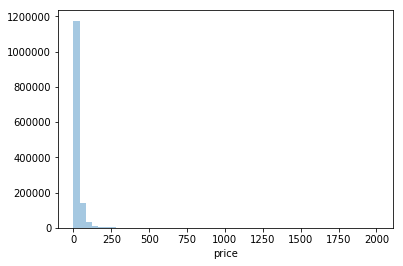

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df=mercari_df['price']
plt.figure(figsize=(6,4))
sns.distplot(y_train_df.dropna(),kde=False)

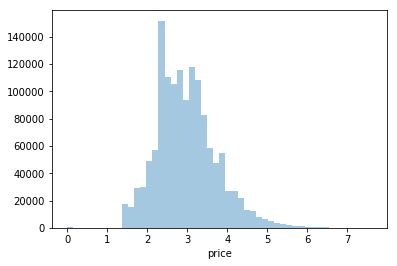

In [18]:
import numpy as np
y_train_df=np.log1p(y_train_df)
sns.distplot(y_train_df.dropna(),kde=False)

In [19]:
mercari_df['price']=np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

In [20]:
print('Shipping 값 유형:\n',mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 0.0    762147
1.0    617062
Name: shipping, dtype: int64
item_condition_id 값 유형:
 1    595938
3    402034
2    349258
4     29764
5      2216
Name: item_condition_id, dtype: int64


In [21]:
boolean_cond=mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

76673

In [22]:
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null', 'Other_Null', 'Other_Null']
    
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so']=zip(*mercari_df['category_name'].apply(lambda x:split_cat(x)))

print('대분류 유형:\n', mercari_df['cat_dae'].value_counts()) #유형&건수 출력

print('중분류 개수:',mercari_df['cat_jung'].nunique()) #분류개수만 출력
print('소분류 개수:',mercari_df['cat_so'].nunique())

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
'test1/test2/test3'.split('/')

In [ ]:
# apply lambda에서 호출되는 대,중,소 분할 함수 생성, 대,중,소 값을 리스트 반환
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null' , 'Other_Null' , 'Other_Null']

# 위의 split_cat( )을 apply lambda에서 호출하여 대,중,소 컬럼을 mercari_df에 생성. 
mercari_df['category_list'] = mercari_df['category_name'].apply(lambda x : split_cat(x))
mercari_df['category_list'].head()

In [ ]:
mercari_df['cat_dae'] = mercari_df['category_list'].apply(lambda x:x[0])
mercari_df['cat_jung'] = mercari_df['category_list'].apply(lambda x:x[1])
mercari_df['cat_so'] = mercari_df['category_list'].apply(lambda x:x[2])

mercari_df.drop('category_list', axis=1, inplace=True) 

In [ ]:
mercari_df[['cat_dae','cat_jung','cat_so']].head()

In [ ]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 컬럼별로 Null값 건수 확인. 모두 0가 나와야 합니다.
mercari_df.isnull().sum()

In [ ]:
mercari_df.info()

[피처 인코딩과 피처 백터화]
- 문자열로 된 열들에 대해, 레이블 or 원-핫 인코딩을 수행하거나, 피처백터화로 변환할 열을 선별하자.
- 상품 가격 (Price)를 예측해야 함.
- 1) 선형회귀 모형, 2) 회귀나무 모형을 모두 적용할 것.
- 특히, 선형회귀는 모두 원-핫 인코딩을 적용함.
- 피처백터화: 1) 비교적 짧은 텍스트: Count 기반의 백터화, 2) 긴 텍스트: TD-IDF 기반의 백터화.

(1) brand_name 열 (브랜드명)

In [ ]:
print('brand name의 유형 건수:', mercari_df['brand_name'].nunique())
print('brand name 샘플 5개: \n', mercari_df['brand_name'].value_counts()[:5])

In [ ]:
print('name 의 종류 갯수 :', mercari_df['name'].nunique())
print('name sample 7건 : \n', mercari_df['name'][:7])

In [ ]:
pd.set_option('max_colwidth',200)

print('item_description 평균 문자열 크기:', mercari_df['item_description'].str.len().mean())
mercari_df['item_description'][:2]